In [1]:
import numpy as np
from tifffile import imread, imsave
from PIL import Image
from PIL.TiffTags import TAGS
import json
from pathlib import Path
import matplotlib.pyplot as plt


In [55]:
def read_si_fullfield_metadata(fullfield_fn):
    '''Reads metadata from a ScanImage full-field tiff file.
    
    Args:
        fullfield_fn: str or Path, path to the full-field tiff file
        
    Returns:
        num_slices: int, number of slices in the z-stack
        num_volumes: int, number of volumes in the z-stack
        num_columns: int, number of columns in the full-field image
    '''
    
    with Image.open(fullfield_fn) as img:
        meta_dict = {TAGS[key] : img.tag[key] for key in img.tag_v2}
    
    num_slices_ind = np.where(['SI.hStackManager.numSlices = ' in x for x in meta_dict['Software'][0].split('\n')])[0][0]
    num_slices_txt = meta_dict['Software'][0].split('\n')[num_slices_ind]
    num_slices = int(num_slices_txt.split('= ')[1])
    
    num_volumes_ind = np.where(['SI.hStackManager.numVolumes = ' in x for x in meta_dict['Software'][0].split('\n')])[0][0]
    num_volumes_txt = meta_dict['Software'][0].split('\n')[num_volumes_ind]
    num_volumes = int(num_volumes_txt.split('= ')[1])

    artist_json = json.loads(meta_dict['Artist'][0])
    num_columns = len(artist_json['RoiGroups']['imagingRoiGroup']['rois'])

    return num_slices, num_volumes, num_columns


def stitch_fullfield(fullfield_fn, channels=[0]):
    '''Stitches a full-field tiff file.

    Args:
        fullfield_fn: str or Path, path to the full-field tiff file
        channels: list of int, channels to stitch
            Only applicable if the full-field tiff file contains multiple channels

    Returns:
        fullfield_stitched: 2D or 3D array, stitched full-field image
    '''
    num_slices, num_volumes, num_columns = read_si_fullfield_metadata(fullfield_fn)
    fullfield_all = imread(fullfield_fn)
    assert fullfield_all.shape[0] == num_slices * num_volumes
    num_rows = int((fullfield_all.shape[1]+1) / num_columns)
    fullfield_stitched = []
    if len(fullfield_all.shape) == 4:
        for channel in channels:
            fullfield = fullfield_all[:,channel,:,:]
            fullfield_stitched.append(_stitch(fullfield, num_slices, num_columns, num_rows))
    else:
        fullfield_stitched.append(_stitch(fullfield_all, num_slices, num_columns, num_rows))
    if len(fullfield_stitched) == 1:
        fullfield_stitched = fullfield_stitched[0]
    else:
        fullfield_stitched = np.stack(fullfield_stitched, axis=0)
    return fullfield_stitched


def _stitch(fullfield, num_slices, num_columns, num_rows):
    ind = np.hstack([np.arange(i, fullfield.shape[0], num_slices) for i in range(num_slices)])
    fullfield_ = np.concatenate([fullfield[ind,:,:],np.zeros((fullfield.shape[0],1,fullfield.shape[2]))], axis=1) 
    fullfield_ = np.concatenate([fullfield_[:, i*num_rows : (i+1)*num_rows, :] for i in range(num_columns)],axis=2)
    im = fullfield_.mean(axis=0)
    return im

In [2]:
fullfield_dir = Path(r'\\allen\programs\braintv\workgroups\ophysdev\OPhysCore\operator_files\vivian_ha\mesoscope_experiements\717489')
fullfield_fn = fullfield_dir / 'fullfield_stack_00001.tif'

In [56]:
stitched = stitch_fullfield(fullfield_fn)
print(stitched.shape)

(-0.5, 1609.5, 1634.5, -0.5)

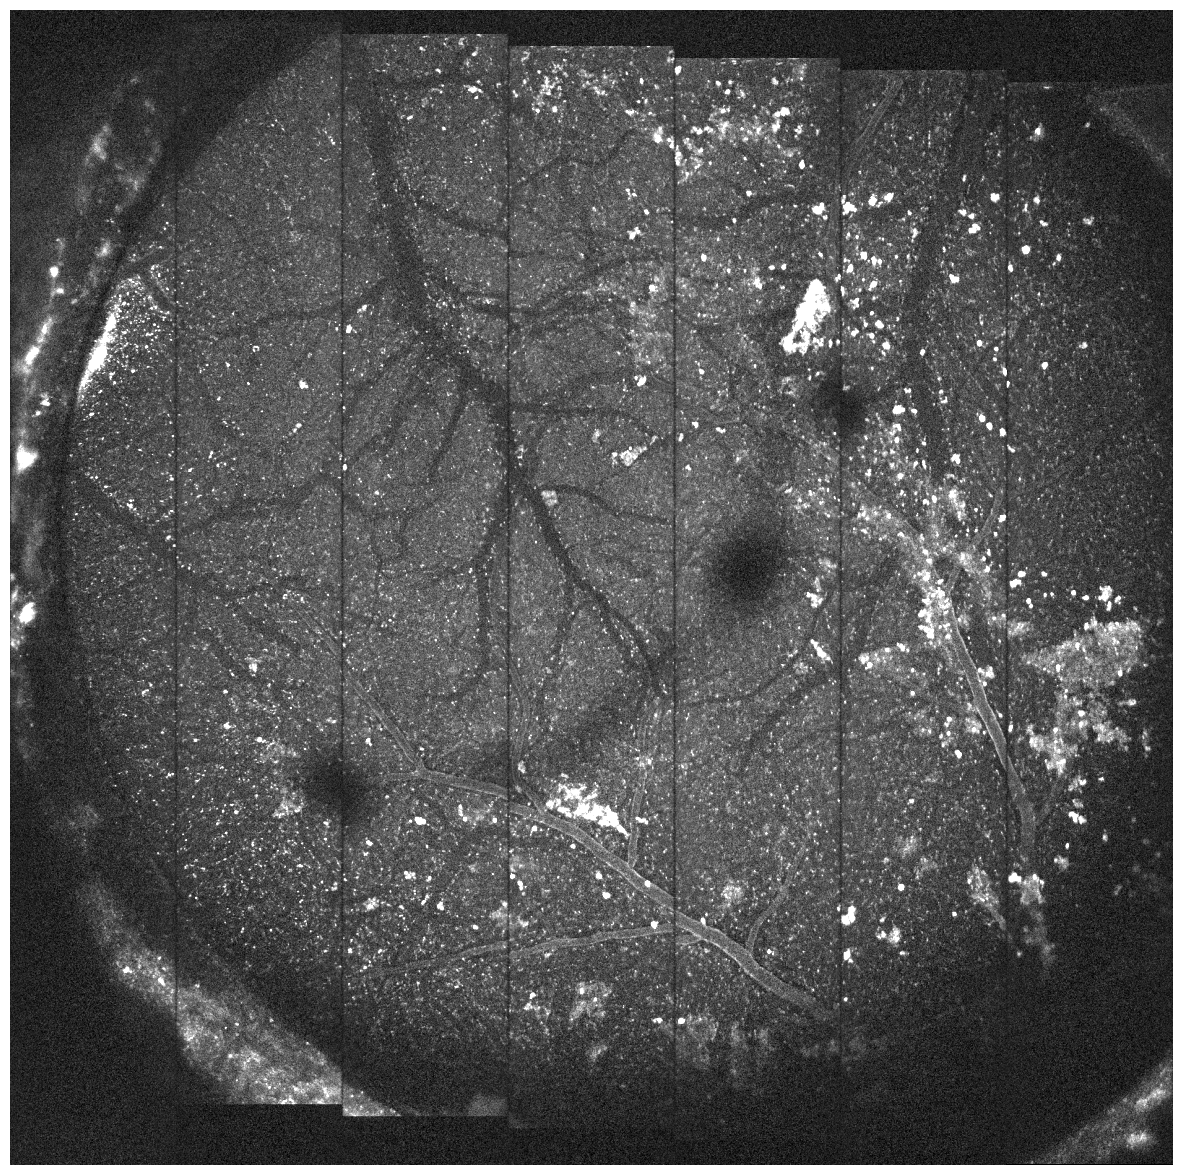

In [59]:
fig = plt.figure(figsize=(15,15))
plt.imshow(stitched,cmap='gray',vmin=np.percentile(stitched,1),vmax=np.percentile(stitched,99),aspect='auto')
plt.axis('off')

In [60]:
save_fn = fullfield_fn.parent / (fullfield_fn.stem + '_stitched.tif')
imsave(save_fn, stitched)

C:\Users\jinho.kim\AppData\Local\Temp\ipykernel_3384\443862753.py:2: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  imsave(save_fn, stitched)
